In [1]:
import gym
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import rl_utils

# 定义策略网络，其输入是状态，输出是动作的概率分布
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=1)

# 定义价值网络，其输入是某个状态，输出则是状态的价值估计
class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)


class PPO:
    ''' PPO算法,采用截断方式 '''
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr, lmbda, epochs, eps, gamma, device):
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device) # 策略网络
        self.critic = ValueNet(state_dim, hidden_dim).to(device)  # 价值网络
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr) # 策略网络优化器
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr) # 价值网络优化器
        self.gamma = gamma
        self.lmbda = lmbda  # GAE（Generalized Advantage Estimation）中的参数，用于计算优势估计
        self.epochs = epochs 
        self.eps = eps  # PPO中截断范围的参数
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        probs = self.actor(state) # 策略网络，对输入状态进行前向传播，得到动作的概率分布
        action_dist = torch.distributions.Categorical(probs)  # 生成动作的概率分布对象
        action = action_dist.sample() # 从概率分布中采样得到动作
        return action.item()  # 返回采样动作

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)

         # 计算时序差分目标作为值函数的目标，用于更新值函数
        td_target = rewards + self.gamma * self.critic(next_states) * (1 - dones)
        # 计算时序差分误差作为策略梯度的误差
        td_delta = td_target - self.critic(states)
        # 计算优势估计
        advantage = rl_utils.compute_advantage(self.gamma, self.lmbda, td_delta.cpu()).to(self.device)
        # 根据选择的动作索引从策略网络输出的概率分布中提取对应的对数概率
        old_log_probs = torch.log(self.actor(states).gather(1,actions)).detach()
        # 循环迭代多次更新策略网络和价值网络
        for _ in range(self.epochs):
            # 通过策略网络对状态进行前向传播，得到动作的概率分布
            log_probs = torch.log(self.actor(states).gather(1, actions))
            # 计算动作比例的指数
            ratio = torch.exp(log_probs - old_log_probs)
            # 计算第一项截断项（surr1）和第二项截断项（surr2），用于计算策略网络的损失函数
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1 - self.eps, 1 + self.eps) * advantage
            # 使用 PPO 损失函数计算策略网络的损失
            actor_loss = torch.mean(-torch.min(surr1, surr2))
            # 使用均方误差损失函数计算值函数的损失
            critic_loss = torch.mean(F.mse_loss(self.critic(states), td_target.detach()))
            # 将策略网络和价值网络的梯度清零
            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()
            # 更新策略网络和价值网络的参数
            actor_loss.backward()
            critic_loss.backward()
            self.actor_optimizer.step()
            self.critic_optimizer.step()

/home/lizhiyuan/miniconda3/envs/ATSC/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 接下来在车杆环境中训练 PPO 算法

actor_lr = 1e-3
critic_lr = 1e-2
num_episodes = 500
hidden_dim = 128
gamma = 0.98
lmbda = 0.95
epochs = 10
eps = 0.2
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

env_name = 'CartPole-v0'
env = gym.make(env_name)
env.seed(0)
torch.manual_seed(0)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = PPO(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, lmbda, epochs, eps, gamma, device)

return_list = rl_utils.train_on_policy_agent(env, agent, num_episodes)

/home/lizhiyuan/miniconda3/envs/ATSC/lib/python3.9/site-packages/gym/envs/registration.py:592: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/home/lizhiyuan/miniconda3/envs/ATSC/lib/python3.9/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/lizhiyuan/miniconda3/envs/ATSC/lib/python3.9/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/lizhiyuan/miniconda3/envs/ATSC/lib/python3.9/site-packages/gym/core.py:268: DeprecationWarning: WARN: Function `env.seed(s

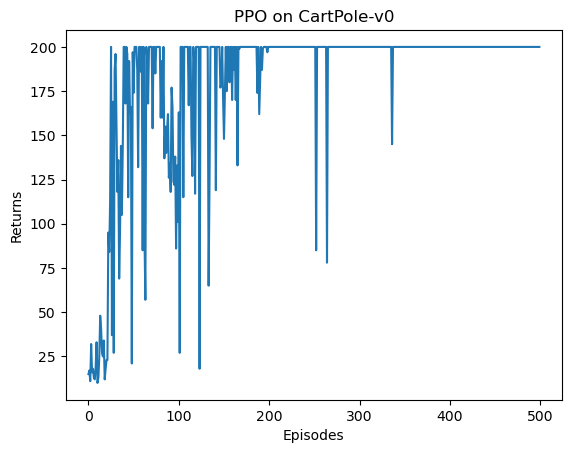

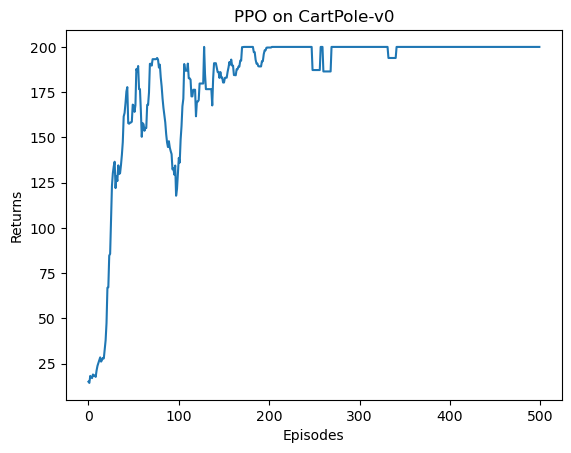

In [3]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}'.format(env_name))
plt.show()

In [4]:
'''
倒立摆是与连续动作交互的环境。在传统的离散动作空间中，策略网络直接输出各个动作的概率分布，并根据概率选择一个动作进行执行。但对于连续动作空间，直接输出动作的概率分布变得困难，因为动作空间是连续的，无法用离散的概率分布来表示。
因此，为了适应连续动作空间，我们需要对策略网络的输出进行修改，使其输出连续动作的高斯分布的均值和标准差。高斯分布是一个连续的概率分布，可以用来描述连续动作的取值范围和概率密度。
在训练过程中，我们从输出的高斯分布中采样得到连续动作，并将其应用于环境中与连续动作交互。通过采样得到的连续动作，可以实现对策略的更新和优化。
在实现 PPO 算法时，将策略网络的输出修改为连续动作的高斯分布的均值和标准差，可以使算法适应连续动作空间的问题，并提供更灵活和表达能力的策略学习方式。
'''

# 定义连续动作空间下的策略网络
class PolicyNetContinuous(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNetContinuous, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc_mu = torch.nn.Linear(hidden_dim, action_dim)
        self.fc_std = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        mu = 2.0 * torch.tanh(self.fc_mu(x)) # 动作均值表示在给定状态下，策略网络输出的动作分布的中心位置。它描述了策略网络认为在该状态下最有可能采取的动作
        std = F.softplus(self.fc_std(x)) # 动作标准差表示在给定状态下，策略网络输出的动作分布的扩展程度或不确定性。它描述了策略网络对动作的方差或分布的宽度的估计
        return mu, std

class PPOContinuous:
    ''' 处理连续动作的PPO算法 '''
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr, lmbda, epochs, eps, gamma, device):
        self.actor = PolicyNetContinuous(state_dim, hidden_dim,action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)
        self.gamma = gamma
        self.lmbda = lmbda
        self.epochs = epochs
        self.eps = eps
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        mu, sigma = self.actor(state) # 使用策略网络对状态进行前向传播，得到动作的均值和标准差
        action_dist = torch.distributions.Normal(mu, sigma) # 使用动作均值和标准差构建动作的正态分布
        action = action_dist.sample() # 采样操作基于正态分布，根据动作均值和标准差生成一个服从该分布的随机样本，得到一个动作
        return [action.item()]

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions'], dtype=torch.float).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)
        rewards = (rewards + 8.0) / 8.0  # 对奖励值进行缩放和归一化
        # 计算时序差分目标作为值函数的目标，用于更新值函数
        td_target = rewards + self.gamma * self.critic(next_states) * (1 - dones)
        # 计算时序差分误差作为策略梯度的误差
        td_delta = td_target - self.critic(states)
        # 计算优势估计
        advantage = rl_utils.compute_advantage(self.gamma, self.lmbda, td_delta.cpu()).to(self.device)
        # 通过策略网络对状态进行前向传播，得到动作的均值和标准差
        mu, std = self.actor(states)
        # 使用动作均值和标准差构建动作的正态分布，并将均值和标准差使用 detach() 方法进行分离，以便在计算梯度时不更新这些参数
        action_dists = torch.distributions.Normal(mu.detach(), std.detach())
        # 计算旧的对数概率，用于后续计算比例比率
        old_log_probs = action_dists.log_prob(actions)

        for _ in range(self.epochs):
            # 在每次迭代中通过策略网络对状态进行前向传播，得到动作的均值和标准差
            mu, std = self.actor(states)
            # 创建一个新的正态分布对象，用于计算新的对数概率
            action_dists = torch.distributions.Normal(mu, std)
            # 计算新的对数概率，用于计算比例比率、PPO 的损失函数和策略梯度更新
            log_probs = action_dists.log_prob(actions)
            # 计算比例比率，表示新策略与旧策略的动作选择概率比例
            ratio = torch.exp(log_probs - old_log_probs)
            # 构造两个截断项，用于计算 PPO 的损失函数
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1 - self.eps, 1 + self.eps) * advantage
            # 基于截断项的最小值，计算策略网络的损失函数
            actor_loss = torch.mean(-torch.min(surr1, surr2))
            # 计算值函数网络的损失函数
            critic_loss = torch.mean(F.mse_loss(self.critic(states), td_target.detach()))
            # 执行梯度优化的步骤：梯度清零、反向传播、参数更新
            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()
            actor_loss.backward()
            critic_loss.backward()
            self.actor_optimizer.step()
            self.critic_optimizer.step()

In [5]:
# 创建环境Pendulum-v1，并设定随机数种子以便重复实现。在倒立摆环境中训练 PPO 算法

actor_lr = 1e-4
critic_lr = 5e-3
num_episodes = 2000
hidden_dim = 128
gamma = 0.9
lmbda = 0.9
epochs = 10
eps = 0.2
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

env_name = 'Pendulum-v1'
env = gym.make(env_name)
env.seed(0)
torch.manual_seed(0)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]  # 连续动作空间
agent = PPOContinuous(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, lmbda, epochs, eps, gamma, device)

return_list = rl_utils.train_on_policy_agent(env, agent, num_episodes)

Iteration 0:   0%|          | 0/200 [00:00<?, ?it/s]

Iteration 9: 100%|██████████| 200/200 [01:12<00:00,  2.75it/s, episode=2000, return=-488.654]


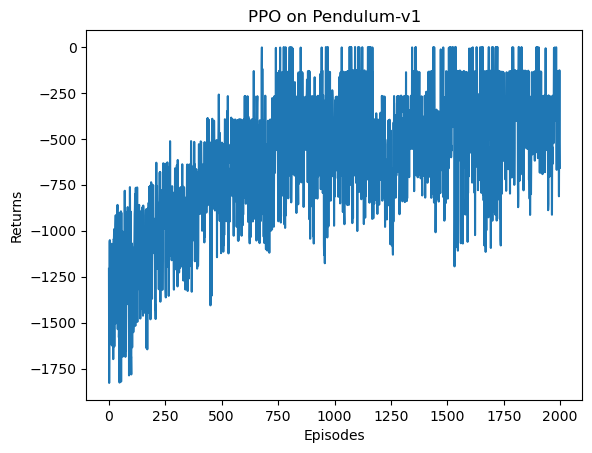

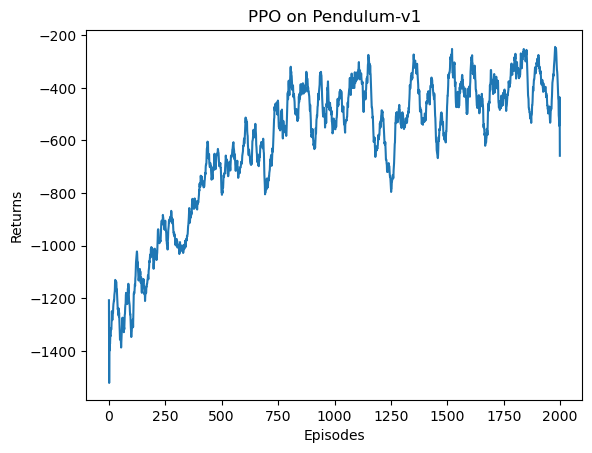

In [6]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 21)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}'.format(env_name))
plt.show()